In [ ]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.2 MB 5.1 MB/s 
     |████████████████████████████████| 86 kB 4.4 MB/s 
     |████████████████████████████████| 596 kB 67.3 MB/s 
     |████████████████████████████████| 6.6 MB 38.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures

model = TFBertForSequenceClassification.from_pretrained("bert-base-chinese",num_labels=5)
tokenizer = BertTokenizer.from_pretrained("bert-base-chinese",)


Downloading:   0%|          | 0.00/624 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-chinese and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Downloading:   0%|          | 0.00/107k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

In [ ]:

model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  102267648 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  3845      
                                                                 
Total params: 102,271,493
Trainable params: 102,271,493
Non-trainable params: 0
_________________________________________________________________


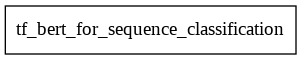

In [ ]:
from tensorflow import keras
keras.utils.plot_model(model,show_shapes=True, show_layer_names=True)

In [ ]:
import tensorflow as tf
import pandas as pd

In [ ]:
import csv
import pandas as pd
train=pd.read_csv('/content/新聞訓練資料.csv', encoding = "cp950")
#test=pd.read_csv('/content/新聞測試資料 (1).csv', encoding = "cp950")


In [ ]:
type(train)

pandas.core.frame.DataFrame

In [ ]:
x_train=train.review
y_train=train.label

In [ ]:
type(x_train)

pandas.core.series.Series

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_train,y_train ,test_size=0.3, random_state=None)#42

In [ ]:
type(x_train)

pandas.core.series.Series

In [ ]:
def convert_data_to_examples(train, test, review, label): 
  train_InputExamples = train.apply(lambda x: InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = x[review], 
                                                          text_b = None,
                                                          label = x[label]),axis=1 )

  validation_InputExamples = test.apply(lambda x: InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = x[review], 
                                                          text_b = None,
                                                          label = x[label]),axis=1 )
  
  return train_InputExamples, validation_InputExamples

  train_InputExamples, validation_InputExamples = convert_data_to_examples(train, 
                                                                           test, 
                                                                           'review', 
                                                                           'label')
  
def convert_examples_to_tf_dataset(examples, tokenizer, max_length=128):
    features = [] # -> will hold InputFeatures to be converted later

    for e in examples:
        # Documentation is really strong for this method, so please take a look at it
        input_dict = tokenizer.encode_plus(
            e.text_a,
            add_special_tokens=True,
            max_length=max_length, # truncates if len(s) > max_length
            return_token_type_ids=True,
            return_attention_mask=True,
            pad_to_max_length=True, # pads to the right by default # CHECK THIS for pad_to_max_length
            truncation=True
        )

        input_ids, token_type_ids, attention_mask = (input_dict["input_ids"],
            input_dict["token_type_ids"], input_dict['attention_mask'])

        features.append(
            InputFeatures(
                input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, label=e.label
            )
        )

    def gen():
        for f in features:
            yield (
                {
                    "input_ids": f.input_ids,
                    "attention_mask": f.attention_mask,
                    "token_type_ids": f.token_type_ids,
                },
                f.label,
            )

    return tf.data.Dataset.from_generator(
        gen,
        ({"input_ids": tf.int32, "attention_mask": tf.int32, "token_type_ids": tf.int32}, tf.int64),
        (
            {
                "input_ids": tf.TensorShape([None]),
                "attention_mask": tf.TensorShape([None]),
                "token_type_ids": tf.TensorShape([None]),
            },
            tf.TensorShape([]),
        ),
    )


review = 'review'
label = 'label'

In [ ]:
train_InputExamples, validation_InputExamples = convert_data_to_examples(train, test,review , label)

train_data = convert_examples_to_tf_dataset(list(train_InputExamples), tokenizer)
train_data = train_data.shuffle(100).batch(32).repeat(2)

validation_data = convert_examples_to_tf_dataset(list(validation_InputExamples), tokenizer)
validation_data = validation_data.batch(32)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2291: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
train_data

In [ ]:
#from keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy('accuracy')]
              )
#callback = EarlyStopping(monitor="loss", patience=10, verbose=1, mode="auto")
history=model.fit(train_data, epochs=10, validation_data=validation_data    )#, callbacks=[callback]

Epoch 1/10
92/92 [==============================] - 100s 833ms/step - loss: 0.5934 - accuracy: 0.7832 - val_loss: 0.2948 - val_accuracy: 0.9250
Epoch 2/10
92/92 [==============================] - 76s 824ms/step - loss: 0.3672 - accuracy: 0.8707 - val_loss: 0.1813 - val_accuracy: 0.9425
Epoch 3/10
92/92 [==============================] - 77s 836ms/step - loss: 0.2398 - accuracy: 0.9222 - val_loss: 0.1173 - val_accuracy: 0.9650
Epoch 4/10
92/92 [==============================] - 77s 840ms/step - loss: 0.1797 - accuracy: 0.9374 - val_loss: 0.0907 - val_accuracy: 0.9650
Epoch 5/10
92/92 [==============================] - 78s 849ms/step - loss: 0.1580 - accuracy: 0.9450 - val_loss: 0.0853 - val_accuracy: 0.9675
Epoch 6/10
92/92 [==============================] - 79s 853ms/step - loss: 0.1435 - accuracy: 0.9457 - val_loss: 0.0610 - val_accuracy: 0.9675
Epoch 7/10
92/92 [==============================] - 78s 852ms/step - loss: 0.1019 - accuracy: 0.9595 - val_loss: 0.0658 - val_accuracy: 0.967

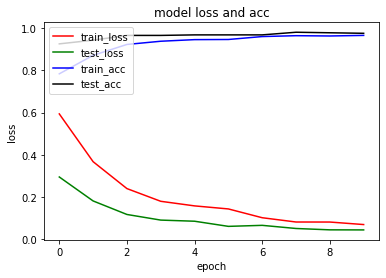

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'],color='r')
plt.plot(history.history['val_loss'],color='g')
plt.plot(history.history['accuracy'],color='b')
plt.plot(history.history['val_accuracy'],color='k')
plt.title('model loss and acc')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'test_loss','train_acc', 'test_acc'], loc='upper left')
plt.show()

In [ ]:
import os

# 模型儲存到的路徑
output_dir = './model_save/'

# 目錄不存在則建立
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# 使用 `save_pretrained()` 來儲存已訓練的模型，模型配置和分詞器
# 它們後續可以通過 `from_pretrained()` 載入
model_to_save = model.module if hasattr(model, 'module') else model  # 考慮到分散式/並行（distributed/parallel）訓練
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))

Saving model to ./model_save/


('./model_save/tokenizer_config.json',
 './model_save/special_tokens_map.json',
 './model_save/vocab.txt',
 './model_save/added_tokens.json')

In [ ]:
pred_sentences=['國泰證券今 (22) 日發布 1 月全球主要股市和商品投資氣象觀察，對於中國、新興亞洲和黃金抱持「正向」看法，其餘如美國、歐洲、日本、新興歐洲、原油、礦業和美元等，則「中性」看待。國泰證指出，今年以來股市表現持續強勁，美元卻呈弱勢，再加上傳統第一季為黃金需求旺季，在實質買盤支撐下，看黃金表現蓄勢待發。國泰證進一步說明，美股高檔震盪趨勢提振黃金的需求，再者，全球貨幣政策和利率環境也影響黃金走勢，以歷史經驗來看，金價與實質利率呈反向關係，長期低利率或負利率的環境有利黃金發展。此外，儘管新興市場去年 GDP 下滑影響實體黃金需求，惟多年累積的財富效果，在未來 GDP 從疫情復甦後，預期實體黃金需求將穩健增加。國泰證券認為，各國債務持續擴大，短期 3-5 年內改善有限，而原物料上漲動能已啟動，低利率和負利率仍將持續一段時間，美元趨勢將持續疲軟，因此，黃金成了持有成本低的貨幣替代資產，尤其面對新冠疫情病毒變種的不定變數，黃金於投資配置上也具有避險的功能。']

In [ ]:
tf_batch = tokenizer(pred_sentences, max_length=128, padding=True, truncation=True, return_tensors='tf')
tf_batch
tf_outputs = model(tf_batch)
tf_predictions = tf.nn.softmax(tf_outputs[0], axis=-1)
labels = ['0','1','2','3','4']
label = tf.argmax(tf_predictions, axis=1)
label = label.numpy()
for i in range(len(pred_sentences)):
  print(pred_sentences[i], ": \n", labels[label[i]])

國泰證券今 (22) 日發布 1 月全球主要股市和商品投資氣象觀察，對於中國、新興亞洲和黃金抱持「正向」看法，其餘如美國、歐洲、日本、新興歐洲、原油、礦業和美元等，則「中性」看待。國泰證指出，今年以來股市表現持續強勁，美元卻呈弱勢，再加上傳統第一季為黃金需求旺季，在實質買盤支撐下，看黃金表現蓄勢待發。國泰證進一步說明，美股高檔震盪趨勢提振黃金的需求，再者，全球貨幣政策和利率環境也影響黃金走勢，以歷史經驗來看，金價與實質利率呈反向關係，長期低利率或負利率的環境有利黃金發展。此外，儘管新興市場去年 GDP 下滑影響實體黃金需求，惟多年累積的財富效果，在未來 GDP 從疫情復甦後，預期實體黃金需求將穩健增加。國泰證券認為，各國債務持續擴大，短期 3-5 年內改善有限，而原物料上漲動能已啟動，低利率和負利率仍將持續一段時間，美元趨勢將持續疲軟，因此，黃金成了持有成本低的貨幣替代資產，尤其面對新冠疫情病毒變種的不定變數，黃金於投資配置上也具有避險的功能。 : 
 1
